In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [3]:
vanilla_data = pd.read_csv('/home/iasl-transformers/DynaSD/results/mt_bench/vanilla_inference_mt_bench_greedy.csv', header=None, names=['target_model', 'speed'])
sd_data = pd.read_csv('/home/iasl-transformers/DynaSD/results/mt_bench/sd_inference_mt_bench_greedy.csv', header=None, names=['draft_model', 'target_model', 'speed', 'acc_rate'])
mcsd_data = pd.read_csv('/home/iasl-transformers/DynaSD/results/mt_bench/mcsd_inference_mt_bench_greedy.csv', header=None, names=['draft_model', 'target_model', 'speed', 'acc_rate'])
dynasd_data = pd.read_csv('/home/iasl-transformers/DynaSD/results/mt_bench/dynasd_inference_mt_bench_greedy.csv', header=None, names=['draft_model', 'target_model', 'speed', 'acc_rate'])

In [4]:
sd_data = sd_data.merge(vanilla_data, on='target_model', suffixes=('', '_vanilla'))
mcsd_data = mcsd_data.merge(vanilla_data, on='target_model', suffixes=('', '_vanilla'))
dynasd_data = dynasd_data.merge(vanilla_data, on='target_model', suffixes=('', '_vanilla'))

sd_data['speedup'] = sd_data['speed'] / sd_data['speed_vanilla']
mcsd_data['speedup'] = mcsd_data['speed'] / mcsd_data['speed_vanilla']
dynasd_data['speedup'] = dynasd_data['speed'] / dynasd_data['speed_vanilla']

In [5]:
print(dynasd_data)

                          draft_model                   target_model  \
0  TinyLlama/TinyLlama-1.1B-Chat-v1.0           lmsys/vicuna-7b-v1.5   
1                  JackFram/llama-68m           lmsys/vicuna-7b-v1.5   
2  TinyLlama/TinyLlama-1.1B-Chat-v1.0  meta-llama/Llama-2-7b-chat-hf   
3                  JackFram/llama-68m  meta-llama/Llama-2-7b-chat-hf   

        speed  acc_rate  speed_vanilla   speedup  
0   82.199654  0.934233      57.655918  1.425693  
1  170.440233  0.769191      57.655918  2.956162  
2   82.181725  0.926123      57.969726  1.417666  
3  156.894977  0.764462      57.969726  2.706499  


In [6]:
model_short_names = {
    'TinyLlama/TinyLlama-1.1B-Chat-v1.0': 'TinyLlama 1.1B',
    'lmsys/vicuna-7b-v1.5': 'Vicuna 7B',
    'meta-llama/Llama-2-7b-chat-hf': 'Llama 2 7B Chat',
    'JackFram/llama-68m': 'Llama 68M',
}

sd_data.replace({'draft_model': model_short_names, 'target_model': model_short_names}, inplace=True)
mcsd_data.replace({'draft_model': model_short_names, 'target_model': model_short_names}, inplace=True)
dynasd_data.replace({'draft_model': model_short_names, 'target_model': model_short_names}, inplace=True)

In [7]:
combined_data = pd.concat([
    sd_data[['draft_model', 'target_model', 'speedup']].assign(method='SD'),
    mcsd_data[['draft_model', 'target_model', 'speedup']].assign(method='MCSD'),
    dynasd_data[['draft_model', 'target_model', 'speedup']].assign(method='DynaSD')
])
print(combined_data)

      draft_model     target_model   speedup  method
0  TinyLlama 1.1B        Vicuna 7B  1.101837      SD
1       Llama 68M        Vicuna 7B  1.561723      SD
2  TinyLlama 1.1B  Llama 2 7B Chat  1.028060      SD
3       Llama 68M  Llama 2 7B Chat  1.496459      SD
0  TinyLlama 1.1B        Vicuna 7B  1.227940    MCSD
1       Llama 68M        Vicuna 7B  1.648261    MCSD
2  TinyLlama 1.1B  Llama 2 7B Chat  1.163976    MCSD
3       Llama 68M  Llama 2 7B Chat  1.583590    MCSD
0  TinyLlama 1.1B        Vicuna 7B  1.425693  DynaSD
1       Llama 68M        Vicuna 7B  2.956162  DynaSD
2  TinyLlama 1.1B  Llama 2 7B Chat  1.417666  DynaSD
3       Llama 68M  Llama 2 7B Chat  2.706499  DynaSD


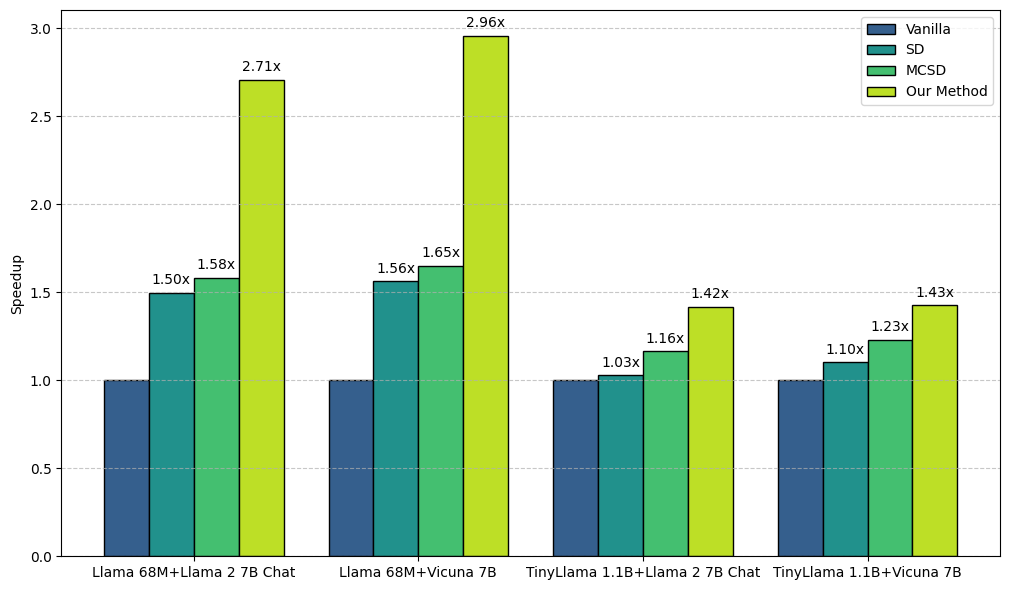

In [8]:
combined_data['label'] = combined_data['draft_model'] + '+' + combined_data['target_model']

combined_data.sort_values(by=['label', 'speedup'], ascending=[True, False], inplace=True)

labels = combined_data['label'].unique()
x = range(len(labels))

color_scale = plt.cm.viridis
color_dynasd = color_scale(0.9)
color_mcsd = color_scale(0.7)
color_sd = color_scale(0.5)
color_vanilla = color_scale(0.3)

plt.figure(figsize=(12, 6))
width = 0.2

plt.bar(x, [1]*len(x), width=width, label='Vanilla', color=color_vanilla, align='center', edgecolor='black') 
plt.bar([p + width for p in x], combined_data[combined_data['method'] == 'SD']['speedup'], 
        width=width, label='SD', color=color_sd, align='center', edgecolor='black')
plt.bar([p + 2*width for p in x], combined_data[combined_data['method'] == 'MCSD']['speedup'], 
        width=width, label='MCSD', color=color_mcsd, align='center', edgecolor='black')
plt.bar([p + 3*width for p in x], combined_data[combined_data['method'] == 'DynaSD']['speedup'], 
        width=width, label='Our Method', color=color_dynasd, align='center', edgecolor='black')

plt.ylabel('Speedup')
plt.xticks([p + 1.5*width for p in x], labels, rotation=0, ha='center', fontsize=10)

plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add legend
plt.legend(loc='best', bbox_to_anchor=(1, 1))

# Annotate each bar with the speedup value
for i, v in enumerate(combined_data[combined_data['method'] == 'DynaSD']['speedup']):
    plt.text(i + 3*width, v + 0.05, f"{v:.2f}x", color='black', ha='center', fontsize=10)

for i, v in enumerate(combined_data[combined_data['method'] == 'MCSD']['speedup']):
    plt.text(i + 2*width, v + 0.05, f"{v:.2f}x", color='black', ha='center', fontsize=10)

for i, v in enumerate(combined_data[combined_data['method'] == 'SD']['speedup']):
    plt.text(i + width, v + 0.05, f"{v:.2f}x", color='black', ha='center', fontsize=10)

plt.tight_layout(rect=[0, 0, 0.85, 1])

plt.show()